In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-2699935716.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process data

In [ ]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

labels = data[:,0]
data = data[:,1:]

labels = torch.tensor(labels, dtype = torch.long)
data = torch.tensor(data, dtype = torch.float)

# normalization
data_norm = data / torch.max(data)

labels, data_norm

(tensor([6, 5, 7,  ..., 2, 9, 5]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data_norm, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

# Model

In [ ]:
def CreateNet():

  class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784, 128)

      self.fc1 = nn.Linear(128,64)
      self.fc2 = nn.Linear(64,64)

      self.output = nn.Linear(64,10)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.output(x)
      return torch.log_softmax(x, axis = 1)

  net = Net()
  loss_fn = nn.NLLLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
  return net, loss_fn, optimizer

CreateNet()

(Net(
   (input): Linear(in_features=784, out_features=128, bias=True)
   (fc1): Linear(in_features=128, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=64, bias=True)
   (output): Linear(in_features=64, out_features=10, bias=True)
 ),
 NLLLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

# Train

In [ ]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = CreateNet()

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  weight_change = np.zeros((epochs, 4))
  weight_conds = np.zeros((epochs, 4))

  for epoch in range(epochs):
    # store the weights for each layer
    pre_weight = []
    for p in net.named_parameters():
      if 'weight' in p[0]:
        pre_weight.append(copy.deepcopy(p[1].data.numpy()))

    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    for (i, p) in enumerate(net.named_parameters()):
      if 'weight' in p[0]:
        # condition number
        weight_conds[epoch, int(i/2)] = np.linalg.cond(p[1].data)

        # Frobenius norm of the weight change from pre-learning
        weight_change[epoch, int(i/2)] = np.linalg.norm(pre_weight[int(i/2)] - p[1].data.numpy(), ord = 'fro')

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses, net, weight_change, weight_conds, pre_weight

In [8]:
train_accs, test_accs, losses, net, weight_change, weight_conds, pre_weight = ModelTrain(epochs = 200, verbose = True)

Epoch: 0 | Train Acc: 10.36 | Test Acc: 12.65 | Loss: 2.30
Epoch: 10 | Train Acc: 87.46 | Test Acc: 87.50 | Loss: 0.44
Epoch: 20 | Train Acc: 91.47 | Test Acc: 90.78 | Loss: 0.30
Epoch: 30 | Train Acc: 93.63 | Test Acc: 92.50 | Loss: 0.22
Epoch: 40 | Train Acc: 95.32 | Test Acc: 93.60 | Loss: 0.17
Epoch: 50 | Train Acc: 96.74 | Test Acc: 94.22 | Loss: 0.13
Epoch: 60 | Train Acc: 97.53 | Test Acc: 94.92 | Loss: 0.10
Epoch: 70 | Train Acc: 98.22 | Test Acc: 95.22 | Loss: 0.07
Epoch: 80 | Train Acc: 98.68 | Test Acc: 95.40 | Loss: 0.06
Epoch: 90 | Train Acc: 99.10 | Test Acc: 95.32 | Loss: 0.04
Epoch: 100 | Train Acc: 99.39 | Test Acc: 95.30 | Loss: 0.03
Epoch: 110 | Train Acc: 99.62 | Test Acc: 95.50 | Loss: 0.02
Epoch: 120 | Train Acc: 99.79 | Test Acc: 95.35 | Loss: 0.02
Epoch: 130 | Train Acc: 99.87 | Test Acc: 95.32 | Loss: 0.01
Epoch: 140 | Train Acc: 99.91 | Test Acc: 95.45 | Loss: 0.01
Epoch: 150 | Train Acc: 99.93 | Test Acc: 95.45 | Loss: 0.01
Epoch: 160 | Train Acc: 99.94 | Tes

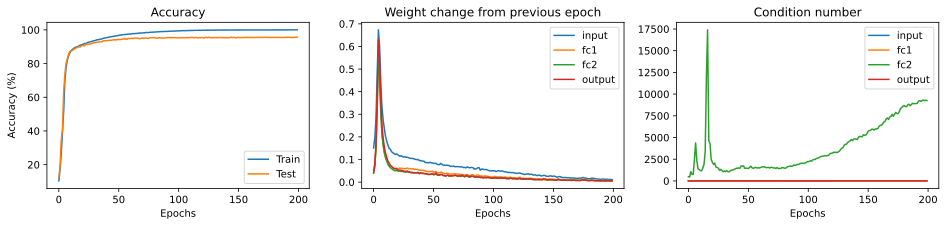

In [13]:
layer_name = []
for (i,p) in enumerate(net.named_parameters()):
  if 'weight' in p[0]:
    layer_name.append(p[0].split('.')[0])

fig, ax = plt.subplots(1,3,figsize = (16,3))

# accuracy
ax[0].plot(train_accs)
ax[0].plot(test_accs)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Accuracy')
ax[0].legend(['Train', 'Test'])

# weight change
ax[1].plot(weight_change)
ax[1].set_xlabel('Epochs')
ax[1].set_title('Weight change from previous epoch')
ax[1].legend(layer_name)

# weight condition numbers
ax[2].plot(weight_conds)
ax[2].set_xlabel('Epochs')
ax[2].set_title('Condition number')
ax[2].legend(layer_name)
# ax[2].set_ylim([0,20])
plt.show()

In [12]:
weight_conds

array([[2.33468127e+00, 5.35575342e+00, 4.91845337e+02, 2.08196282e+00],
       [2.34077787e+00, 5.32750511e+00, 4.52651367e+02, 2.07848096e+00],
       [2.35656667e+00, 5.28305960e+00, 1.06692041e+03, 2.11552930e+00],
       [2.70461750e+00, 5.68248129e+00, 7.72770386e+02, 2.51128435e+00],
       [3.42671394e+00, 6.80477571e+00, 7.62969788e+02, 3.20919776e+00],
       [3.90040779e+00, 7.50100374e+00, 2.42730249e+03, 3.52431250e+00],
       [4.23159599e+00, 7.82753372e+00, 4.37473975e+03, 3.64361405e+00],
       [4.41196871e+00, 8.04658413e+00, 2.35883057e+03, 3.69706225e+00],
       [4.51078796e+00, 8.22721004e+00, 1.39634180e+03, 3.74086976e+00],
       [4.58168125e+00, 8.37765980e+00, 1.30935559e+03, 3.77306533e+00],
       [4.62260771e+00, 8.50888443e+00, 1.17873975e+03, 3.80358124e+00],
       [4.63690042e+00, 8.63189316e+00, 1.17471155e+03, 3.83502412e+00],
       [4.66434956e+00, 8.71079922e+00, 1.48174463e+03, 3.85229778e+00],
       [4.68068361e+00, 8.78916264e+00, 1.89334802e

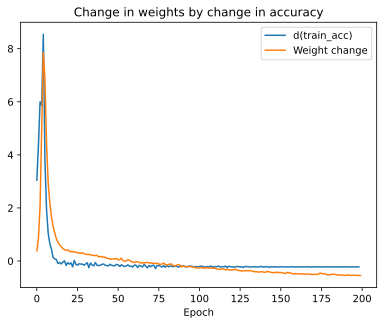

In [17]:
# final inspection: check the derivative of acc agains the wieght change
from scipy.stats import zscore

plt.plot(zscore(np.diff(train_accs)), label = 'd(train_acc)')
plt.plot(zscore(np.mean(weight_change, axis = 1)), label = 'Weight change')
plt.legend()
plt.title('Change in weights by change in accuracy')
plt.xlabel('Epoch')
plt.show()